In [1]:
from torchinfo import summary
from fvcore.nn import FlopCountAnalysis
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from lightning.pytorch import seed_everything
import lightning as L
import torch
import seaborn as sns
import numpy as np
import json
import argparse
import matplotlib.pyplot as plt
import scienceplots
import os
from model_modules import *
from data_modules import *
%load_ext autoreload
%autoreload 2

plt.style.use('science')

In [2]:
def load_ckpt(model_class, run_name, file_name):
    ckpt_path = os.path.join("Satelite-Interference",
                             run_name, "checkpoints", file_name)
    model = model_class.load_from_checkpoint(ckpt_path)
    return model


models = [
    [LinearAE, "qnz17vpr", "linear_ae_epoch=103-step=9360-val_loss=0.02.ckpt"],
    [LinearVAE, "bkvapq2t", "linear_vae_epoch=386-step=34830-val_loss=0.02.ckpt"],
    [CNNAE, "wtgwzqaa", "cnn_ae_epoch=115-step=10440-val_loss=0.02.ckpt"],
    [CNNVAE, "dqho97xp", "cnn_vae_epoch=223-step=20160-val_acc=0.02.ckpt"],
    [TransformerAE, "ish762qv", "transformer_ae_epoch=320-step=28890-val_acc=0.00.ckpt"],
    [TransformerVAE, "qxmwpa49", "transformer_vae_epoch=235-step=21240-val_acc=0.03.ckpt"],
]

In [3]:
data_module = BaseDataModule(batch_size=128)
data_module.prepare_data()
data_module.setup(stage="test")
test_loader = data_module.test_dataloader()
print(test_loader)

In [4]:
def test_model(model, test_loader):
    model.eval()
    reconstruction_errors = []
    all_true_labels = []

    with torch.no_grad():
        for batch in test_loader:
            signal = batch['signal'].to(model.device)
            spectrum = batch['spectrum'].to(model.device)
            labels = batch['label'].cpu().numpy()

            # Forward pass
            if isinstance(model, AE):
                recon_signal, recon_spectrum = model(signal, spectrum)
            elif isinstance(model, VAE):
                recon_signal, recon_spectrum, _, _ = model(signal, spectrum)
            else:
                raise ValueError("Model must be an instance of AE or VAE")

            # Calculate combined reconstruction error
            error_signal = torch.mean(
                (recon_signal - signal)**2, dim=[1, 2]).cpu().numpy()
            error_spectrum = torch.mean(
                (recon_spectrum - spectrum)**2, dim=[1, 2]).cpu().numpy()
            total_error = error_signal + error_spectrum

            reconstruction_errors.extend(total_error)
            all_true_labels.extend(labels)

    reconstruction_errors = np.array(reconstruction_errors)
    all_true_labels = np.array(all_true_labels)

    # Calculate metrics
    threshold = np.percentile(reconstruction_errors, 60)
    predicted_labels = (reconstruction_errors > threshold).astype(int)

    fpr, tpr, _ = roc_curve(all_true_labels, reconstruction_errors)
    roc_auc_val = auc(fpr, tpr)

    return {
        'reconstruction_errors': reconstruction_errors,
        'predicted_labels': predicted_labels,
        'threshold': threshold,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc_val,
        'confusion_matrix': confusion_matrix(all_true_labels, predicted_labels),
        'classification_report': classification_report(all_true_labels, predicted_labels,
                                                       target_names=['Interference-free', 'Interference'])
    }

In [5]:
results = {}
for model_class, run_name, file_name in models:
    model = load_ckpt(model_class, run_name, file_name)
    results[model.__class__.__name__] = test_model(model, test_loader)

/home/sledge/miniconda3/envs/comfyui/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/sledge/miniconda3/envs/comfyui/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


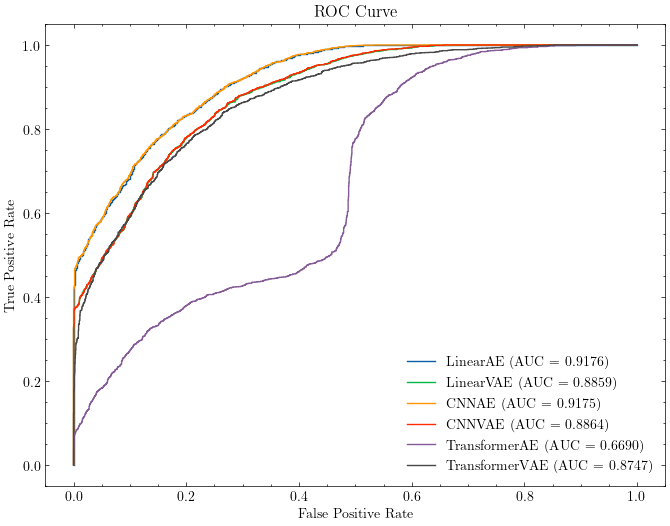

In [6]:
def plot_comparative_roc(results):
    """Plot ROC curve for CNN model"""
    plt.figure(figsize=(8, 6))
    for model_name, metrics in results.items():
        plt.plot(metrics['fpr'], metrics['tpr'],
                 label=f'{model_name} (AUC = {metrics["roc_auc"]:.4f})')

    # plt.plot([0, 1], [0, 1], color='navy', lw=2,
        #  linestyle='--', label='Random Guess')
    # plt.xlim([-0.01, 1.0])
    # plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    # plt.grid(True)
    plt.show()


plot_comparative_roc(results)

In [9]:
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"Metrics: {metrics['confusion_matrix']}")

Model: LinearAE
Metrics: [[2017  235]
 [ 665 1553]]
Model: LinearVAE
Metrics: [[1955  297]
 [ 727 1491]]
Model: CNNAE
Metrics: [[2019  233]
 [ 663 1555]]
Model: CNNVAE
Metrics: [[1956  296]
 [ 726 1492]]
Model: TransformerAE
Metrics: [[1450  802]
 [1232  986]]
Model: TransformerVAE
Metrics: [[1944  308]
 [ 738 1480]]


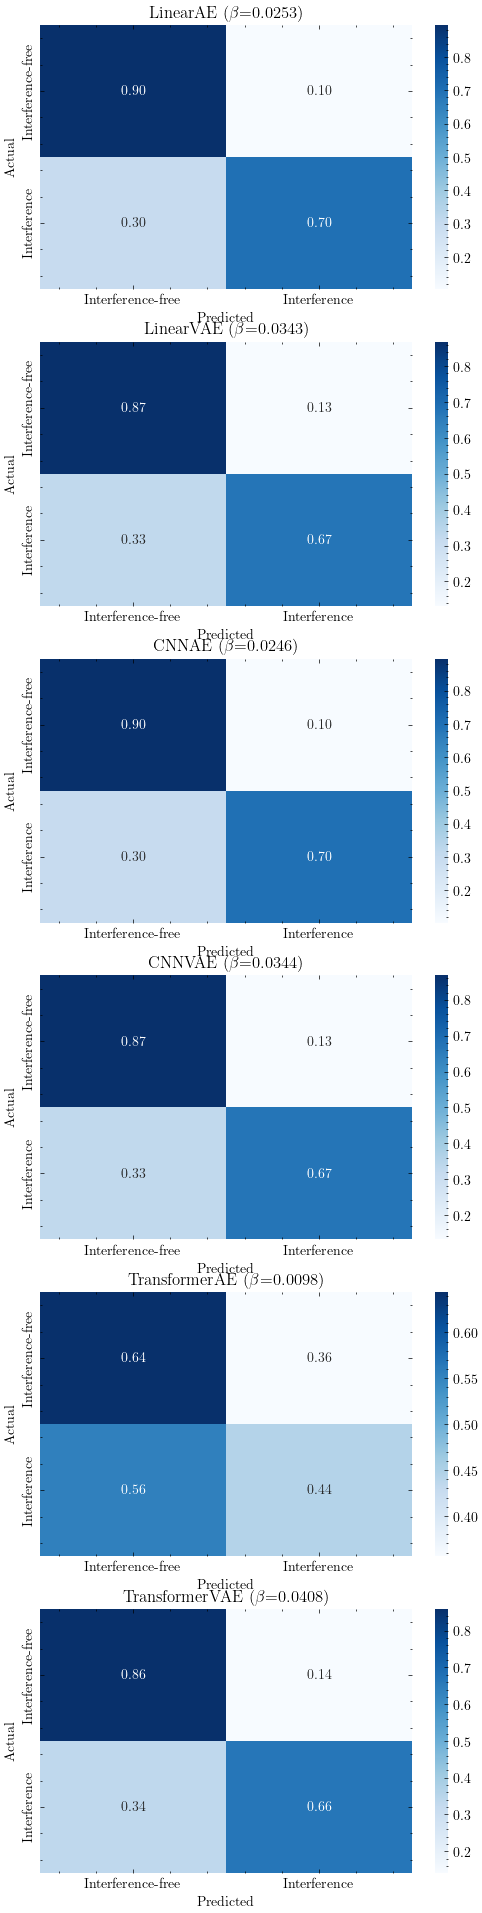

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_comparative_confusion_matrices(results, normalize=True):
    """Plot normalized confusion matrices for CNN model."""
    num_models = len(results)
    fig, axes = plt.subplots(num_models, 1, figsize=(6, 4*num_models))

    for ax, (model_name, metrics) in zip(axes, results.items()):
        cm = metrics['confusion_matrix']
        
        if normalize:
            cm = cm.astype(np.float64) / cm.sum(axis=1, keepdims=True)  # Normalize by row (true class)

        sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap='Blues',
                    xticklabels=['Interference-free', 'Interference'],
                    yticklabels=['Interference-free', 'Interference'], ax=ax)

        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title(f'{model_name} ($\\beta$={metrics["threshold"]:.4f})')

    # plt.tight_layout()
    # plt.show()

# Example usage:
plot_comparative_confusion_matrices(results)
